# Human Preference Dataset– Data Preprocessing

- [Dataset Paper](https://arxiv.org/abs/2009.01325)
- [Dataset on HuggingFace](https://huggingface.co/datasets/openai/summarize_from_feedback)

In [ ]:
!pip install datasets transformers torch seaborn --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 125.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━ 403.7/664.8 MB 120.0 MB/s eta 0:00:03

In [ ]:
from datasets import load_dataset
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
ds = load_dataset("openai/summarize_from_feedback", "comparisons")
print("Available splits:", ds.keys())

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/1.61k [00:00<?, ?B/s]

summarize_from_feedback.py:   0%|          | 0.00/9.38k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/21.1M [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/22.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/92858 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/86086 [00:00<?, ? examples/s]

Available splits: dict_keys(['train', 'validation'])


In [ ]:
sample = ds["train"][0]
print("\nSample data structure:\n")
for key, value in sample.items():
    print(f"{key}: {value if isinstance(value, str) else str(value)[:200]}")



Sample data structure:

info: {'id': 't3_34xale', 'post': "My boyfriend and I are long distance. We have a trip planned this summer which involves me going over to him in the USA. This will be the second time I have actually been 
summaries: [{'text': ' Mum is mad at me for not flying on my own trip to meet my boyfriend.', 'policy': 'sup1', 'note': None}, {'text': ' I have made sure my mother is comfortable with my boyfriend travelling on
choice: 1
worker: qo6WIyEh27cwAjWpA3Q60J7NaDxzQJ
batch: batch3
split: train
extra: {'confidence': None}


In [ ]:
df = pd.DataFrame(ds["train"])
print("\nTotal rows in training split:", len(df))


Total rows in training split: 92858


In [ ]:
preferred = df["choice"].value_counts().sort_index()
print("\nPreference distribution (0 = summary_0, 1 = summary_1):\n", preferred)


Preference distribution (0 = summary_0, 1 = summary_1):
 choice
0    45852
1    47006
Name: count, dtype: int64


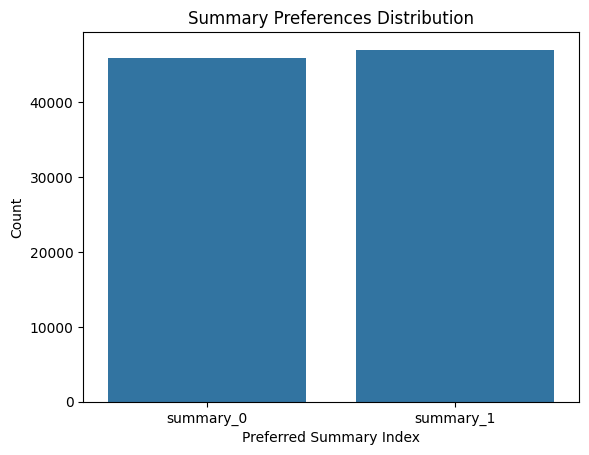

In [ ]:
sns.barplot(x=preferred.index, y=preferred.values)
plt.title("Summary Preferences Distribution")
plt.xlabel("Preferred Summary Index")
plt.ylabel("Count")
plt.xticks([0, 1], ['summary_0', 'summary_1'])
plt.show()

# Reward Model Setup

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer

# Define dataset class
class PreferenceDataset(Dataset):
    def __init__(self, hf_dataset, tokenizer, max_length=512):
        self.data = hf_dataset
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        chosen = item['summaries'][item['choice']]['text']
        rejected = item['summaries'][1 - item['choice']]['text']

        chosen_enc = self.tokenizer(chosen, truncation=True, padding="max_length", max_length=self.max_length, return_tensors="pt")
        rejected_enc = self.tokenizer(rejected, truncation=True, padding="max_length", max_length=self.max_length, return_tensors="pt")

        return {
            'chosen_input_ids': chosen_enc['input_ids'].squeeze(0),
            'chosen_attention_mask': chosen_enc['attention_mask'].squeeze(0),
            'rejected_input_ids': rejected_enc['input_ids'].squeeze(0),
            'rejected_attention_mask': rejected_enc['attention_mask'].squeeze(0),
        }

## Reward Model

In [ ]:
import torch.nn as nn
from transformers import AutoModel

# Define reward model using a transformer base
class RewardModel(nn.Module):
    def __init__(self, base_model_name="distilbert-base-uncased"):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(base_model_name)
        self.regressor = nn.Linear(self.encoder.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        cls_rep = outputs.last_hidden_state[:, 0, :]  # [CLS] token
        score = self.regressor(cls_rep)
        return score.squeeze(-1)

## Forward Pass

In [ ]:
# Setup tokenizer, dataset, dataloader
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
train_dataset = PreferenceDataset(ds["train"], tokenizer)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

reward_model = RewardModel()

# Try one forward pass
batch = next(iter(train_loader))

with torch.no_grad():
    reward_chosen = reward_model(batch['chosen_input_ids'], batch['chosen_attention_mask'])
    reward_rejected = reward_model(batch['rejected_input_ids'], batch['rejected_attention_mask'])

print("\nSample Reward Scores (Chosen):", reward_chosen[:5])
print("Sample Reward Scores (Rejected):", reward_rejected[:5])

# Calculate margin-based loss (e.g., pairwise hinge loss or log-loss)
loss_fn = nn.MarginRankingLoss(margin=1.0)
target = torch.ones_like(reward_chosen)  # chosen should be ranked higher
loss = loss_fn(reward_chosen, reward_rejected, target)

print("Sample Pairwise Loss:", loss.item())


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]


Sample Reward Scores (Chosen): tensor([0.2228, 0.2352, 0.2701, 0.1946, 0.2608])
Sample Reward Scores (Rejected): tensor([0.3121, 0.2617, 0.1667, 0.1360, 0.2027])
Sample Pairwise Loss: 0.9582505822181702


## Training for 5 Epochs

In [ ]:
import torch
import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
reward_model = reward_model.to(device)

# Loss function & optimizer
loss_fn = nn.MarginRankingLoss(margin=1.0)
optimizer = Adam(reward_model.parameters(), lr=2e-5)

# Training loop
num_epochs = 5
epoch_losses = []
reward_model.train()

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    epoch_loss = 0.0
    steps = 0

    for batch in tqdm(train_loader, desc="Training"):
        # Move batch to device
        chosen_ids = batch['chosen_input_ids'].to(device)
        chosen_mask = batch['chosen_attention_mask'].to(device)
        rejected_ids = batch['rejected_input_ids'].to(device)
        rejected_mask = batch['rejected_attention_mask'].to(device)

        # Forward pass
        reward_chosen = reward_model(chosen_ids, chosen_mask)
        reward_rejected = reward_model(rejected_ids, rejected_mask)

        # Compute pairwise loss (we want chosen > rejected)
        target = torch.ones_like(reward_chosen).to(device)
        loss = loss_fn(reward_chosen, reward_rejected, target)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        steps += 1

        # Print progress every 100 steps
        if steps % 100 == 0:
            print(f"Step {steps}: Current Loss = {loss.item():.4f}")

    avg_epoch_loss = epoch_loss / steps
    epoch_losses.append(avg_epoch_loss)
    print(f"\Epoch {epoch+1} Average Loss: {avg_epoch_loss:.4f}")

plt.plot(range(1, num_epochs + 1), epoch_losses, marker='o')
plt.title("Reward Model Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Average Pairwise Loss")
plt.grid(True)
plt.show()

Using device: cuda

Epoch 1/5


Training:   1%|          | 100/11608 [01:08<2:14:15,  1.43it/s]

Step 100: Current Loss = 0.6872


Training:   2%|▏         | 200/11608 [02:19<2:14:11,  1.42it/s]

Step 200: Current Loss = 0.8926


Training:   3%|▎         | 300/11608 [03:30<2:14:17,  1.40it/s]

Step 300: Current Loss = 0.8648


Training:   3%|▎         | 400/11608 [04:41<2:11:50,  1.42it/s]

Step 400: Current Loss = 0.8439


Training:   4%|▍         | 500/11608 [05:52<2:11:46,  1.40it/s]

Step 500: Current Loss = 0.6707


Training:   5%|▌         | 600/11608 [07:03<2:09:53,  1.41it/s]

Step 600: Current Loss = 0.5709


Training:   6%|▌         | 700/11608 [08:14<2:09:10,  1.41it/s]

Step 700: Current Loss = 0.6129


Training:   7%|▋         | 800/11608 [09:25<2:07:38,  1.41it/s]

Step 800: Current Loss = 1.0258


Training:   8%|▊         | 900/11608 [10:36<2:06:36,  1.41it/s]

Step 900: Current Loss = 1.0687


Training:   9%|▊         | 1000/11608 [11:47<2:06:55,  1.39it/s]

Step 1000: Current Loss = 0.7993


Training:   9%|▉         | 1100/11608 [12:58<2:04:16,  1.41it/s]

Step 1100: Current Loss = 0.8252


Training:  10%|▉         | 1107/11608 [13:03<2:03:27,  1.42it/s]

## Save Model

In [ ]:
# Save full model
torch.save(reward_model.state_dict(), "reward_model.pt")
print("Reward model saved as reward_model.pt")

## Test on Validation Set

In [ ]:
# Load validation split
val_dataset = PreferenceDataset(ds["validation"], tokenizer)
val_loader = DataLoader(val_dataset, batch_size=8)

reward_model.eval()
val_loss_total = 0.0
val_steps = 0

with torch.no_grad():
    for batch in tqdm(val_loader, desc="Evaluating"):
        chosen_ids = batch['chosen_input_ids'].to(device)
        chosen_mask = batch['chosen_attention_mask'].to(device)
        rejected_ids = batch['rejected_input_ids'].to(device)
        rejected_mask = batch['rejected_attention_mask'].to(device)

        reward_chosen = reward_model(chosen_ids, chosen_mask)
        reward_rejected = reward_model(rejected_ids, rejected_mask)

        target = torch.ones_like(reward_chosen).to(device)
        loss = loss_fn(reward_chosen, reward_rejected, target)

        val_loss_total += loss.item()
        val_steps += 1

avg_val_loss = val_loss_total / val_steps
print(f"\Average Validation Pairwise Loss: {avg_val_loss:.4f}")


NameError: name 'PreferenceDataset' is not defined